<a href="https://colab.research.google.com/github/rohanwagh01/036-MachineLearning/blob/main/MIT_6_036_HW07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MIT 6.036 Fall 2020: Homework 7#

This colab notebook provides code and a framework for problem 2-4 of the homework.  You can work out your solutions here, then submit your results back on the homework page when ready.

**Note**: You can go to `File > Save a copy in Drive...` to save your own copy of this notebook for editing.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.


In [1]:
!rm -rf code_for_hw7*
!rm -rf mnist
!rm -rf data
!wget --no-check-certificate --quiet https://go.odl.mit.edu/subject/6.036/_static/catsoop/homework/hw07/code_for_hw7.zip
!unzip code_for_hw7.zip
!mv code_for_hw7/* .

from code_for_hw7 import *
import numpy as np
import modules_disp as disp


Archive:  code_for_hw7.zip
   creating: code_for_hw7/
  inflating: code_for_hw7/code_for_hw7.py  
  inflating: code_for_hw7/pytorch_code_for_hw7.py  
  inflating: code_for_hw7/code_for_hw7_pytorch.py  
   creating: code_for_hw7/data/
  inflating: code_for_hw7/data/data5_validate.csv  
  inflating: code_for_hw7/data/data5_train.csv  
  inflating: code_for_hw7/data/data1_train.csv  
  inflating: code_for_hw7/data/data1_validate.csv  
  inflating: code_for_hw7/data/data2_train.csv  
  inflating: code_for_hw7/data/data2_validate.csv  
  inflating: code_for_hw7/data/data3_train.csv  
  inflating: code_for_hw7/data/data3_validate.csv  
  inflating: code_for_hw7/data/data3class_train.csv  
  inflating: code_for_hw7/data/data4_train.csv  
  inflating: code_for_hw7/data/data4_validate.csv  
  inflating: code_for_hw7/data/dataXor_train.csv  
  inflating: code_for_hw7/expected_results.py  
  inflating: code_for_hw7/modules_disp.py  
  inflating: code_for_hw7/utils_hw7.py  
   creating: code_for_h

# 2) Implementing Neural Networks

This homework considers neural networks with multiple layers. Each layer has multiple inputs and outputs, and can be broken down into two parts:
 
<br>
 
A linear module that implements a linear transformation:     $ z_j = (\sum^{m}_{i=1} x_i W_{i,j}) + {W_0}_jz$

specified by a weight matrix $W$ and a bias vector $W_0$. The input is $[x_1, \ldots, x_m]^T$. The output is $[z_1, \ldots, z_n]^T$

<br>

An activation module that applies an activation function to the outputs of the linear module for some activation function $f$, such as Tanh or ReLU in the hidden layers or Softmax (see below) at the output layer. We write the output as: $[f(z_1), \ldots, f(z_m)]^T$, although technically, for some activation functions such as softmax, each output will depend on all the $z_i$.

Although for "real" applications you want to use one of the many packaged implementations of neural networks (we'll start using one of those soon), there is no substitute for implementing one yourself to get an in-depth understanding. Luckily, that is relatively easy to do if we're not too concerned with maximum efficiency.

We'll use the modular implementation that we guided you through in the previous problem, which leads to clean code. The basic framework for SGD training is given below. We can construct a network and train it as follows:

```
# build a 3-layer network
net = Sequential([Linear(2,3), Tanh(),
                  Linear(3,3), Tanh(),
    	          Linear(3,2), SoftMax()])
# train the network on data and labels
net.sgd(X, Y)
```
We will (later) be generalizing SGD to operate on a "mini-batch" of data points instead of a single point. You should strive for an implementation of the forward, backward, and `class_fun` methods that works with batches of data. Note that when $b$ is mentioned as part of the shape of a matrix in the code, this $b$ refers to the number of points.

## Linear Modules: ##
Each linear module has a forward method that takes in a batch of activations A (from the previous layer) and returns a batch of pre-activations Z.

Each linear module has a backward method that takes in dLdZ and returns dLdA. This module also computes and stores dLdW and dLdW0, the gradients with respect to the weights.

Hint: be careful with dimensions when computing dLdW0. dLdZ is (n x b), but dLdW0 is (n x 1). Why do you need to sum over all $b$ points in the batch when computing dLdW0?

In [2]:
class Linear(Module):
    def __init__(self, m, n):
        # initializes the weights randomly and offsets as 0
        self.m, self.n = (m, n)  # (in size, out size)
        self.W0 = np.zeros([self.n, 1])  # (n x 1)
        self.W = np.random.normal(0, 1.0 * m ** (-.5), [m, n])  # (m x n)

    def forward(self, A):
        # store the input matrix for future use
        self.A = A   # (m x b)  Hint: make sure you understand what b stands for
        return (self.W).T@A+self.W0@np.ones((1,A.shape[1]))  # Your code (n x b)

    def backward(self, dLdZ):  
        # dLdZ is (n x b), uses stored self.A
        # store the derivatives for use in sgd_step and returd dLdA
        self.dLdW = self.A@np.transpose(dLdZ)       # Your code
        self.dLdW0 = dLdZ@np.ones((self.A.shape[1],1))      # Your code
        return self.W@dLdZ            # Your code: return dLdA (m x b)

    def sgd_step(self, lrate):  # Gradient descent step
        self.W = self.W-lrate*self.dLdW           # Your code
        self.W0 = self.W0-lrate*self.dLdW0          # Your code
             # Your code

 You are **highly encouraged** to make your own tests for each module. The test cases being run on catsoop are given below for your reference:

In [3]:
def nn_linear_forward():
    np.random.seed(0)
    linear = Linear(2,3)
    X,Y = super_simple_separable()
    return linear.forward(X).tolist()

expected_linear_forward = [[10.417500637754383, 6.911221682745654, 20.733665048236965, 22.891234399772113], [7.168722346625092, 3.489987464919749, 10.469962394759248, 9.998261102396512], [-2.071054548689073, 0.6941371647696142, 2.0824114943088414, 4.849668106971125]]
print("Pass linear forward? ", np.allclose(nn_linear_forward(), expected_linear_forward))

def nn_linear_forward_bias():
    np.random.seed(0)
    linear = Linear(2,3)
    linear.W0 = np.array([[1],[1],[1]])
    X,Y = super_simple_separable()
    return linear.forward(X).tolist()

expected_linear_forward_bias = [[11.417500637754383, 7.911221682745654, 21.733665048236965, 23.891234399772113], [8.168722346625092, 4.489987464919749, 11.469962394759248, 10.998261102396512], [-1.071054548689073, 1.6941371647696142, 3.0824114943088414, 5.849668106971125]]
print("Pass linear forward bias? ", np.allclose(nn_linear_forward_bias(), expected_linear_forward_bias))



Pass linear forward?  True
Pass linear forward bias?  True


In [4]:
def nn_linear_backward():
    np.random.seed(0)
    linear = Linear(2,3)
    X,Y = super_simple_separable()
    linear.forward(X)
    dLdZ = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0],
                                     [3, 0, 0, 1]])
    return linear.backward(dLdZ).tolist()

expected_linear_backward = [[3.889497924054116, 1.247373376201773, 0.2829538755771419, 0.6920722655660196], [2.1525571673658237, 1.5845507770701677, 1.3205629190941617, -0.6910398159642225]]
print("Pass linear backward? ", np.allclose(nn_linear_backward(), expected_linear_backward))

def nn_linear_backward_stored_dLdW_dLdW0():
    np.random.seed(0)
    linear = Linear(2,3)
    X,Y = super_simple_separable()
    linear.forward(X)
    dLdZ = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0],
                                     [3, 0, 0, 1]])
    linear.backward(dLdZ)
    return [linear.dLdW.tolist(), linear.dLdW0.tolist()]

expected_linear_backward_stored = [[[5, 13, 18], [7, 16, 20]], [[2], [3], [4]]]
print("Pass linear backward stored vals dLdW? ", np.allclose(nn_linear_backward_stored_dLdW_dLdW0()[0], expected_linear_backward_stored[0]))
print("Pass linear backward stored vals dLdW0? ", np.allclose(nn_linear_backward_stored_dLdW_dLdW0()[1], expected_linear_backward_stored[1]))

def nn_linear_sgd():
    np.random.seed(0)
    linear = Linear(2,3)
    X,Y = super_simple_separable()
    linear.forward(X)
    dLdZ = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0],
                                     [3, 0, 0, 1]])
    linear.backward(dLdZ)
    linear.sgd_step(0.005)
    return [np.vstack([linear.W, linear.W0.T]).tolist()]

expected_linear_sgd = [[[1.222373376201773, 0.2179538755771419, 0.6020722655660197], [1.5495507770701678, 1.2405629190941616, -0.7910398159642225], [-0.01, -0.015, -0.02]]]
print("Pass linear sgd? ", np.allclose(nn_linear_sgd(), expected_linear_sgd))

Pass linear backward?  True
Pass linear backward stored vals dLdW?  True
Pass linear backward stored vals dLdW0?  True
Pass linear sgd?  True


The following datasets are defined for your use:
*  `super_simple_separable_through_origin()`
*  `super_simple_separable()`
*  `xor()`
*  `xor_more()`
*  `hard()`

Further, a plotting function is defined for your usage in modules_disp.py, and can be called in the colab notebook as `disp.plot_nn()`.
```
def plot_nn(X, Y, nn):
    """ Plot output of nn vs. data """
    def predict(x):
        return nn.modules[-1].class_fun(nn.forward(x))[0]
    xmin, ymin = np.min(X, axis=1)-1
    xmax, ymax = np.max(X, axis=1)+1
    nax = plot_objective_2d(lambda x: predict(x), xmin, xmax, ymin, ymax)
    plot_data(X, Y, nax)
    plt.show()```


## Activation functions: ##
Each activation module has a forward method that takes in a batch of pre-activations Z and returns a batch of activations A.

Each activation module has a backward method that takes in dLdA and returns dLdZ, with the exception of SoftMax, where we assume dLdZ is passed in.

### Tanh: ###
Please use np.tanh here. You can find documentation online.

Hint: the derivative of $\tanh$ is given by $\frac{d\tanh(z)}{d z} = 1 - \tanh(z)^2$.

In [5]:
class Tanh(Module):            # Layer activation
    def forward(self, Z):
        self.A = np.tanh(Z)            # Your code
        return self.A

    def backward(self, dLdA):    # Uses stored self.A
        return dLdA*(np.ones((self.A.shape))-self.A*self.A)
        # Your code: return dLdZ
    

Tanh unit test:

In [6]:
def nn_tanh_forward():
    np.random.seed(0)
    tanh = Tanh()
    X,Y = super_simple_separable()
    return tanh.forward(X).tolist()

expected_tanh_forward = [[0.9640275800758169, 0.9950547536867305, 0.999999969540041, 0.9999999999244973], [0.9999092042625951, 0.9640275800758169, 0.9999877116507956, 0.9999092042625951]]
print("Pass tanh forward? ", np.allclose(nn_tanh_forward(), expected_tanh_forward))

def nn_tanh_backward():
    np.random.seed(0)
    tanh = Tanh()
    X,Y = super_simple_separable()
    tanh.forward(X)
    dLdA = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0]])
    return tanh.backward(dLdA).tolist()

expected_tanh_backward = [[0.07065082485316443, 0.009866037165440211, 0.0, 0.0], [0.0003631664618877206, 0.0, 2.4576547405286142e-05, 0.0]]
print("Pass tanh backward? ", np.allclose(nn_tanh_backward(), expected_tanh_backward))

Pass tanh forward?  True
Pass tanh backward?  True


### ReLU: ###
Hint:
[`np.maximum`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.maximum.html) might be useful.

In [7]:
class ReLU(Module):              # Layer activation
    def forward(self, Z):
        self.A = np.maximum(0,Z)            # Your code
        return self.A

    def backward(self, dLdA):    # uses stored self.A
        return dLdA*(self.A/self.A)              # Your code: return dLdZ
               # Your code: return dLdZ (?, b)

ReLU unit tests:

In [8]:
def nn_relu_forward():
    np.random.seed(0)
    relu = ReLU()
    X,Y = super_simple_separable()
    return relu.forward(X).tolist()

expected_relu_forward = [[2, 3, 9, 12], [5, 2, 6, 5]]
print("Pass relu forward? ", np.allclose(nn_relu_forward(), expected_relu_forward))

def nn_relu_backward():
    np.random.seed(0)
    relu = ReLU()
    X,Y = super_simple_separable()
    relu.forward(X)
    dLdA = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0]])
    return relu.backward(dLdA).tolist()

expected_relu_backward = [[1, 1, 0, 0], [2, 0, 1, 0]]
print("Pass relu backward? ", np.allclose(nn_relu_backward(), expected_relu_backward))


Pass relu forward?  True
Pass relu backward?  True


###SoftMax: ###
For `SoftMax.class_fun()`, given the column vector of class probabilities for each point (computed by Softmax), return a vector of the classes (integers) with the highest probability for each point. The output should be a 1D numpy array. 

In [9]:
class SoftMax(Module):           # Output activation
    def forward(self, Z):
        Z_e = np.exp(Z)
        e_sum = np.sum(Z_e, axis=0)
        return Z_e/e_sum

    def backward(self, dLdZ):    # Assume that dLdZ is passed in
        return dLdZ

    def class_fun(self, Ypred):  
        # Returns the index of the most likely class for each point as vector of shape (b,)
        return np.argmax(Ypred, axis=0) # Your code             # Your code: A 1D vector (b, ) 

Test cases for softmax:

In [10]:
def nn_softmax_forward():
    np.random.seed(0)
    softmax = SoftMax()
    X,Y = super_simple_separable()
    return softmax.forward(X).tolist()

expected_softmax_forward = [[0.04742587317756679, 0.7310585786300048, 0.9525741268224334, 0.9990889488055993], [0.9525741268224333, 0.2689414213699951, 0.04742587317756678, 0.0009110511944006454]]
print("Pass softmax forward? ", np.allclose(nn_softmax_forward(), expected_softmax_forward))
  
def nn_softmax_class_fun():
    np.random.seed(0)
    softmax = SoftMax()
    X,Y = super_simple_separable()
    Ypred = softmax.forward(X)
    return softmax.class_fun(Ypred).tolist()

expected_softmax_class_fun = [1, 0, 0, 0]
print("Pass softmax class fun? ", np.allclose(nn_softmax_class_fun(), expected_softmax_class_fun))

Pass softmax forward?  True
Pass softmax class fun?  True


## Loss Functions:##
Each loss module has a forward method that takes in a batch of predictions Ypred (from the previous layer) and labels Y and returns a scalar loss value. Each column of Y will correspond to a one-hot vector encoding the correct class label for one point in our batch. 

The NLL module has a backward method that returns dLdZ, the gradient with respect to the preactivation to SoftMax (note: not the activation!), since we are always pairing SoftMax activation with NLL loss.

### NLL: ###
You should use multi-class NLL. 

Hint: $$\frac{dNLL(Softmax(z))}{dz} = Y_{pred} - Y$$

As an exercise, try proving that this is true.

In [11]:
class NLL(Module):       # Loss
    def forward(self, Ypred, Y):
        # returns loss as a float
        self.Ypred = Ypred
        self.Y = Y
        return -np.sum(Y*np.log(Ypred))      # Your code

    def backward(self):  # Use stored self.Ypred, self.Y
        # note, this is the derivative of loss with respect to the input of softmax
        return self.Ypred-self.Y      # Your code

NLL Test Cases:

In [12]:
def nn_nll_forward():
    nll = NLL()
    y = np.array([[1, 0, 1, 0]])
    Y = for_softmax(y)
    ypred = np.array([[.7, .3, .99, .99]])
    Ypred = for_softmax(ypred)
    return nll.forward(Ypred, Y)

expected_nll_forward = 5.328570409719057
print("Pass nll forward? ", np.allclose(nn_nll_forward(), expected_nll_forward))

def nn_nll_backward():
    nll = NLL()
    y = np.array([[1, 0, 1, 0]])
    Y = for_softmax(y)
    ypred = np.array([[.7, .3, .99, .99]])
    Ypred = for_softmax(ypred)
    nll.forward(Ypred, Y)
    return nll.backward().tolist()

expected_nll_backward = [[0.30000000000000004, -0.30000000000000004, 0.010000000000000009, -0.99], [-0.30000000000000004, 0.3, -0.010000000000000009, 0.99]]
print("Pass nll backward? ", np.allclose(nn_nll_backward(), expected_nll_backward))

Pass nll forward?  True
Pass nll backward?  True


## Activation and Loss Test Cases: ##
Run Test 1 and Test 2 below and compare your outputs with the expected outputs.


In [13]:
# TEST 1: sgd_test for Tanh activation and SoftMax output
np.random.seed(0)
sgd_test(Sequential([Linear(2,3), Tanh(), Linear(3,2), SoftMax()], NLL()), test_1_values)

linear_1.W: OK
linear_1.W0: OK
linear_2.W: OK
linear_2.W0: OK
z_1: OK
a_1: OK
z_2: OK
a_2: OK
loss: OK
dloss: OK
dL_dz2: OK
dL_da1: OK
dL_dz1: OK
dL_dX: OK
updated_linear_1.W: OK
updated_linear_1.W0: OK
updated_linear_2.W: OK
updated_linear_2.W0: OK


In [14]:
# TEST 2: sgd_test for ReLU activation and SoftMax output
np.random.seed(0)
sgd_test(Sequential([Linear(2,3), ReLU(), Linear(3,2), SoftMax()], NLL()), test_2_values)

linear_1.W: OK
linear_1.W0: OK
linear_2.W: OK
linear_2.W0: OK
z_1: OK
a_1: OK
z_2: OK
a_2: OK
loss: OK
dloss: OK
dL_dz2: OK
dL_da1: OK
dL_dz1: FAILED
expected: [[ 6.28919807e-01 -3.52832568e-02  6.35791049e-01 -2.30458563e-04]
 [-2.93387075e-01  1.64594141e-02 -2.96592466e-01  1.07507449e-04]
 [-0.00000000e+00  4.19713676e-02 -7.56308297e-01  2.74143091e-04]]
but was: [[ 6.28919807e-01 -3.52832568e-02  6.35791049e-01 -2.30458563e-04]
 [-2.93387075e-01  1.64594141e-02 -2.96592466e-01  1.07507449e-04]
 [            nan  4.19713676e-02 -7.56308297e-01  2.74143091e-04]]
dL_dX: FAILED
expected: [[ 7.01482813e-01 -1.03069207e-02  1.85726843e-01 -6.73213966e-05]
 [ 6.09119276e-01 -6.31763062e-02  1.13841333e+00 -4.12646736e-04]]
but was: [[            nan -1.03069207e-02  1.85726843e-01 -6.73213966e-05]
 [            nan -6.31763062e-02  1.13841333e+00 -4.12646736e-04]]
updated_linear_1.W: FAILED
expected: [[ 1.21301666  0.29898107  0.72546012]
 [ 1.55011264  1.33662809 -0.66877713]]
but was:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


## Neural Network: ##

Implement SGD. Randomly pick a data point Xt, Yt by using np.random.randint to choose a random index into the data. Compute the predicted output Ypred for Xt with the forward method. Compute the loss for Ypred relative to Yt. Use the backward method to compute the gradients. Use the sgd_step method to change the weights. Repeat.

Hint: First call `Sequential.loss.backward()` to get dLdZ (in the case of the NLL loss function) before calling `Sequential.backward` with dLdZ as your input to propagate the loss backward through the layers.

In [15]:
 class Sequential:
    def __init__(self, modules, loss):            # List of modules, loss module
        self.modules = modules
        self.loss = loss

    def sgd(self, X, Y, iters=100, lrate=0.005):  # Train
        D, N = X.shape
        sum_loss = 0
        for it in range(iters):
            n = np.random.randint(N)
            Xt = X[:, n:n+1]
            Yt = Y[:, n:n+1]
            Ypred = self.forward(Xt)
            sum_loss += self.loss.forward(Ypred,Yt)
            b = self.loss.backward()
            self.backward(b)
            self.sgd_step(lrate)

    def forward(self, Xt):                        # Compute Ypred
        for m in self.modules: Xt = m.forward(Xt)
        return Xt

    def backward(self, delta):                    # Update dLdW and dLdW0
        # Note reversed list of modules
        for m in self.modules[::-1]: delta = m.backward(delta)

    def sgd_step(self, lrate):                    # Gradient descent step
        for m in self.modules: m.sgd_step(lrate)

    def print_accuracy(self, it, X, Y, cur_loss, every=250):
        # Utility method to print accuracy on full dataset, should
        # improve over time when doing SGD. Also prints current loss,
        # which should decrease over time. Call this on each iteration
        # of SGD!
        if it % every == 1:
            cf = self.modules[-1].class_fun
            acc = np.mean(cf(self.forward(X)) == cf(Y))
            print('Iteration =', it, '	Acc =', acc, '	Loss =', cur_loss)


## Neural Network / SGD Test Cases: ##
Use Test 3 to help you debug.

In [16]:
# TEST 3: try calling these methods that train with a simple dataset
def nn_tanh_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), Tanh(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=1, lrate=0.005)
    return [np.vstack([nn.modules[0].W, nn.modules[0].W0.T]).tolist(),
            np.vstack([nn.modules[2].W, nn.modules[2].W0.T]).tolist()]


def nn_relu_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), ReLU(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=2, lrate=0.005)
    return [np.vstack([nn.modules[0].W, nn.modules[0].W0.T]).tolist(),
            np.vstack([nn.modules[2].W, nn.modules[2].W0.T]).tolist()]


def nn_pred_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), ReLU(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=1, lrate=0.005)
    Ypred = nn.forward(X)
    return nn.modules[-1].class_fun(Ypred).tolist(), [nn.loss.forward(Ypred, Y)]


In [17]:
nn_tanh_test()

# Expected output:
# '''
# [[[1.2473733761848262, 0.2829538808226157, 0.6924193292712828],
#   [1.5845507770278007, 1.320562932207846, -0.6901721567010647],
#   [-8.47337764291184e-12, 2.6227368810847106e-09, 0.00017353185263155828]],
#  [[0.544808855557535, -0.08366117689965663],
#   [-0.06331837550937104, 0.24078409926389266],
#   [0.08677202043839037, 0.8360167748667923],
#   [-0.0037249480614718, 0.0037249480614718]]]
# '''

[[[1.2473733761848262, 0.2829538808226157, 0.6924193292712828],
  [1.5845507770278007, 1.320562932207846, -0.6901721567010647],
  [-8.47337764291184e-12, 2.6227368810847102e-09, 0.00017353185263155828]],
 [[0.544808855557535, -0.08366117689965663],
  [-0.06331837550937103, 0.24078409926389266],
  [0.08677202043839037, 0.8360167748667923],
  [-0.0037249480614717995, 0.0037249480614718]]]

In [18]:
nn_relu_test()

# Expected output:
# '''
# [[[1.2421914999646917, 0.2851239946607419, 0.6905003767490479],
#   [1.5695659964519526, 1.3273884281993562, -0.6920877418422037],
#   [-0.0027754917572235106, 0.001212351486908601, -0.0005239629389906042]],
#  [[0.501769700845158, -0.040622022187279644],
#   [-0.09260786974986723, 0.27007359350438886],
#   [0.08364438851530624, 0.8391444067898763],
#   [-0.004252310922204504, 0.004252310922204505]]]
# '''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


[[[nan, nan, nan], [nan, nan, nan], [nan, nan, nan]],
 [[nan, nan], [nan, nan], [nan, nan], [nan, nan]]]

In [19]:
nn_pred_test()

# Expected output:
# '''
# ([0, 0, 0, 0], [8.56575061835767])
# '''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


([0, 0, 0, 0], [nan])

# 3) 2D Datasets

For the 2D datasets, we have provided the following function:

>```run_pytorch_2d(data_name, layers, epochs, split=0.25, display=True, trials=5)```

where:

* `data_name` is a string, such as '1', '2', etc. 
* `layers` is a list of torch.nn layer definitions for a Sequential model, e.g.
> ```[nn.Linear(in_features=2, out_features=classes, bias=True), nn.Softmax(dim=-1)]```
* `epochs` is an integer indicating how many times to go through the data in training 
* `split` is a fraction of the training data to use for validation if a validation set is not defined 
* `display` whether to display result plots 
* `verbose` whether to print loss and accuracy (percent correctly labeled) each epoch 
* `trials` is an integer indicating how many times to perform the training and testing 

The two-class datasets have `data_name`s: `'1'`,`'2'`,`'3'`,`'4'`.

In this problem, try the following 5 architectures, specified by the number of units in the hidden layers:

`0: (), 1: (10), 2: (100), 3: (100, 10), 4: (100, 100)`

You may find the `archs` function below to be helpful here. Some of these questions ask for the "simplest" architecture; the list above is ordered starting with the simplest.

In [20]:
from utils_hw7 import plot_heat, get_data_loader, model_fit, model_evaluate, run_pytorch, dataset_paths

In [21]:
import numpy as np
import itertools
import math as m
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [22]:
######################################################################
# Problem 3 - 2D data
######################################################################

def archs(classes):
    # param: classes (int) determines the size of the pre-activations before they go into softmax.
    # return: (dict) a dictionary mapping integers 0-4 to architectures with increasing complexity.
    return {0: [
                nn.Linear(in_features=2, out_features=classes, bias=True),
            ],
            1: [
                nn.Linear(in_features=2, out_features=10, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=10, out_features=classes, bias=True),
            ],
            2: [
                nn.Linear(in_features=2, out_features=100, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=classes, bias=True),
            ],
            3: [
                nn.Linear(in_features=2, out_features=100, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=10, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=10, out_features=classes, bias=True),
            ],
            4: [
                nn.Linear(in_features=2, out_features=100, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=100, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=classes, bias=True),
            ]
           }

In [23]:
"""
This function is also in utils_hw7.
We write it here just to bring it to your attention.
Please try to go through it.
"""

def call_model(mode, model, data_iter, optimizer, criterion):
    epoch_loss = []
    hits = []
    items = []
    
    if mode == 'train':
        model.train()
        grad_mode = torch.enable_grad()
    else:
        model.eval()
        grad_mode = torch.no_grad()

    with grad_mode:

        for batch in data_iter:
            X, y = batch.X, batch.y

            if mode == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()

            # forward
            y_hat = model(X)
            batch_loss = criterion(y_hat, y.long())

            if mode == 'train':
                # backward + optimize
                batch_loss.backward()
                optimizer.step()

            epoch_loss.append(batch_loss.item())
            hits.append((y_hat.argmax(1) == y).sum())
            items.append(X.shape[0])

        loss = np.sum(epoch_loss)/np.sum(items)
        acc_score = np.sum(hits)/np.sum(items)
        return loss, acc_score

In [24]:
"""
This function is also in utils_hw7.
We write it here just to bring it to your attention because
you'll be running (but not modifying) this function for this
homework.
Please try to go through it.
"""

def run_pytorch_2d(data_name, layers, epochs, split=0.25, display=True,
                   verbose=True, trials=1, batch_size=32):
    print('Pytorch FC: dataset=', data_name)
    (train_dataset_path, val_dataset_path, test_dataset_path) = dataset_paths(data_name)
    # Load the datasets
    train_iter, num_classes = get_data_loader(train_dataset_path, batch_size)
    val_iter, num_classes = get_data_loader(val_dataset_path, batch_size)
    test_iter, num_classes = get_data_loader(test_dataset_path, batch_size)
    
    if val_iter is None:
        # Use split
        print("Use split", train_iter)
        assert split > 0, '`split` must be > 0'
        train_iter, val_iter,  num_classes = get_data_loader(train_dataset_path, batch_size, split)

    val_acc, test_acc = 0, 0
    X_train = torch.cat([batch.X for batch in train_iter], 0)
    y_train = torch.cat([batch.y for batch in train_iter], 0)
    
    for trial in range(trials):
        trial_history = {'epoch_loss': [], 'epoch_val_loss': [],
               'epoch_acc': [], 'epoch_val_acc': []}
    
        if verbose: print("\n")
        print(f'# Trial {trial}')
        
        # Run the model
        model, vacc, tacc, = run_pytorch(train_iter, val_iter, test_iter, 
                                         layers, epochs, split=split,
                                         verbose=verbose, history=trial_history)

        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
        if display:
            # plot classifier landscape on training data
            plot_heat(X_train, y_train, model)
            plt.title('Training data')
            plt.show()
            if test_iter is not None:
                # plot classifier landscape on testing data
                X_test = torch.cat([batch.X for batch in test_iter], 0)
                y_test = torch.cat([batch.y for batch in test_iter], 0)
                plot_heat(X_test, y_test, model)
                plt.title('Testing data')
                plt.show()
            # Plot epoch loss
            plt.figure(facecolor="white")
            plt.plot(range(epochs), trial_history['epoch_loss'], label='epoch_train_loss')
            plt.plot(range(epochs), trial_history['epoch_val_loss'], label='epoch_val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.title('Epoch val_loss and loss')
            plt.legend()
            plt.show()
            # Plot epoch accuracy
            plt.figure(facecolor="white")
            plt.plot(range(epochs), trial_history['epoch_acc'], label='epoch_train_acc')
            plt.plot(range(epochs), trial_history['epoch_val_acc'], label='epoch_val_acc')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.title('Epoch val_acc and acc')
            plt.show()
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))
        
   
    return X_train, y_train, model

## 3A-D)
Here are some examples of how you can run the pytorch functions. You'll need to write your own code to run the experiments in parts A-D.

Pytorch FC: dataset= 1
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.03647 acc 0.055 | VALI: loss 0.03903 acc 0.05
epoch: 1 | TRAIN: loss 0.03531 acc 0.0575 | VALI: loss 0.03776 acc 0.05
epoch: 2 | TRAIN: loss 0.03418 acc 0.06 | VALI: loss 0.03652 acc 0.05
epoch: 3 | TRAIN: loss 0.03307 acc 0.0625 | VALI: loss 0.03532 acc 0.055
epoch: 4 | TRAIN: loss 0.03201 acc 0.0675 | VALI: loss 0.03416 acc 0.055
epoch: 5 | TRAIN: loss 0.03097 acc 0.07 | VALI: loss 0.03303 acc 0.06
epoch: 6 | TRAIN: loss 0.02997 acc 0.075 | VALI: loss 0.03194 acc 0.07
epoch: 7 | TRAIN: loss 0.029 acc 0.0925 | VALI: loss 0.03089 acc 0.09
epoch: 8 | TRAIN: loss 0.02806 acc 0.1075 | VALI: loss 0.02987 acc 0.125
epoch: 9 | TRAIN: loss 0.02716 acc 0.1375 | VALI: loss 0.0289 acc 0.155



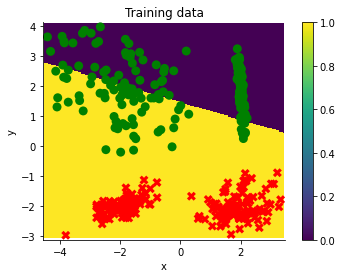

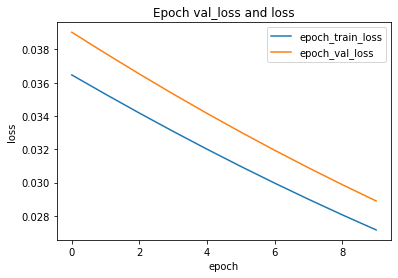

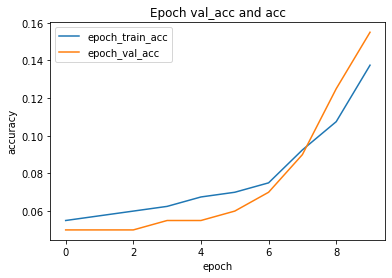


Avg. validation accuracy:0.076


In [25]:
layer_dict = archs(2) # implies we have 2 classification classes
layers = layer_dict[0] # using architecture 0

# this will train on dataset "1"
X_train, y_train, model = run_pytorch_2d("1", layers, epochs=10, trials = 1, verbose=True, display=True)

In [26]:
# if you don't care about the return values, throw them into a trash variable
_ = run_pytorch_2d("3class",archs(3)[2], 10, split=.5, display=False, verbose=False, trials=20)

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7f6719279990>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.903975


## 3E)

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7f671921b690>
Using validation split
train_size 600 val_size 200
Loading train X torch.Size([600, 2]) y torch.Size([600]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0, 2.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.03511 acc 0.26167 | VALI: loss 0.03859 acc 0.27
epoch: 1 | TRAIN: loss 0.03408 acc 0.32 | VALI: loss 0.03749 acc 0.295
epoch: 2 | TRAIN: loss 0.0331 acc 0.40333 | VALI: loss 0.03644 acc 0.42
epoch: 3 | TRAIN: loss 0.03217 acc 0.53333 | VALI: loss 0.03544 acc 0.53
epoch: 4 | TRAIN: loss 0.03129 acc 0.6 | VALI: loss 0.0345 acc 0.585
epoch: 5 | TRAIN: loss 0.03045 acc 0.635 | VALI: loss 0.0336 acc 0.595
epoch: 6 | TRAIN: loss 0.02965 acc 0.655 | VALI: loss 0.03275 acc 0.615
epoch: 7 | TRAIN: loss 0.02889 acc 0.67333 | VALI: loss 0.03195 acc 0.67
epoch: 8 | TRAIN: loss 0

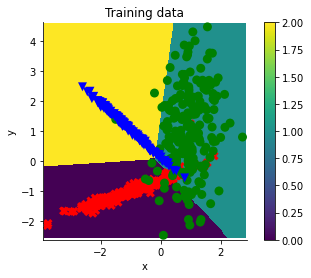

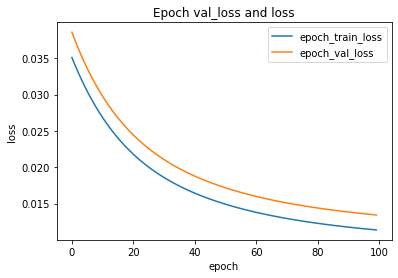

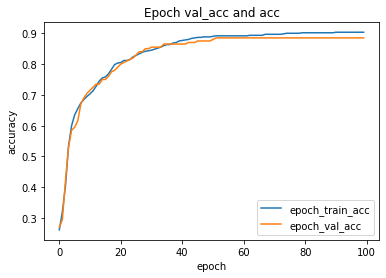


Avg. validation accuracy:0.8272000000000002


In [27]:
points = np.array([[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]])

deterministic = True
if deterministic:
  torch.manual_seed(10)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(10)

layer_dict = archs(3) # implies we have 2 classification classes
layers = layer_dict[0] # using architecture 0

X_train, y_train, model = run_pytorch_2d("3class", layers, epochs=100, trials=1, verbose=True, display=True)

# 4) Optimizers

In this question, we're going to return to the non-convex function from lab 3.

In [28]:
import abc

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from io import BytesIO, StringIO
import base64

import plotly.graph_objects 
import plotly.tools 

In [29]:
def tidy_plot(xmin, xmax, ymin, ymax, center = False, title = None,
                 xlabel = None, ylabel = None):
    plt.figure(facecolor="white")
    ax = plt.subplot()
    if center:
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('zero')
        ax.spines['top'].set_color('none')
        # ax.spines['left'].set_smart_bounds(True)	# 2021-07-26 no longer available
        # ax.spines['bottom'].set_smart_bounds(True)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    else:
        ax.spines["top"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        ax.get_xaxis().tick_bottom()  
        ax.get_yaxis().tick_left()
    eps = .05
    plt.xlim(xmin-eps, xmax+eps)
    plt.ylim(ymin-eps, ymax+eps)
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    return ax

def plot_fun(ax, f, xmin, xmax, nPts = 100, label = None):
    x = np.linspace(xmin, xmax, nPts)
    y = cv([float(f(xi)) for xi in x])
    ax.plot(x, y, label = label)
    return savefig()

def plot_points(x, y, ax = None, clear = False, 
                  xmin = None, xmax = None, ymin = None, ymax = None,
                  style = 'or-', equal = False, mark_initial = False, mark_final = False):
    padup = lambda v: v + 0.05 * abs(v)
    paddown = lambda v: v - 0.05 * abs(v)
    if ax is None:
        if xmin == None: xmin = paddown(np.min(x))
        if xmax == None: xmax = padup(np.max(x))
        if ymin == None: ymin = paddown(np.min(y))
        if ymax == None: ymax = padup(np.max(y))
        ax = tidy_plot(xmin, xmax, ymin, ymax)
        x_range = xmax - xmin; y_range = ymax - ymin
        if equal and .1 < x_range / y_range < 10:
            #ax.set_aspect('equal')
            plt.axis('equal')
            if x_range > y_range:
                ax.set_xlim((xmin, xmax))
            else:
                ax.set_ylim((ymin, ymax))
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
    elif clear:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        ax.clear()
    else:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(x, y, style, markeredgewidth=0.0, linewidth = 3.0)
    if mark_initial:  
      ax.plot(x[0], y[0], 'xb', markersize = 12)
    if mark_final:
      ax.plot(x[-1], y[-1], 'Db', markersize = 6)
    # Seems to occasionally mess up the limits
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.grid(True, which='both')
    return ax


def plotly2html(fig):
    '''
    Return HTML for plotly figure.
    Note that the plotly js library is NOT included; this must be added, e.g. in preload.py with

    cs_scripts += """<script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: 'local'};</script>"""
    cs_scripts += """<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>"""

    '''
    with StringIO() as ofp:
        fig.write_html(ofp, auto_open=False, include_plotlyjs=False, full_html=False)
        ofp.seek(0)
        fig_output = ofp.read()
    return fig_output


def savefig_plotly(legend=False, width=720, height=400):
    '''
    Attempt to generate a plotly figure from a matplotlib figure.
    Doesn't always work!
    '''
    def is_frame_like(self, *args, **kwargs):
        return False
    matplotlib.spines.Spine.is_frame_like = is_frame_like
    fig = plotly.tools.mpl_to_plotly(plt.gcf())
    if legend:
        fig['layout']['showlegend'] = True
    fig.update_layout(width=width, height=height)
    return plotly2html(fig)

def savefig():
    b = BytesIO()
    plt.savefig(b)
    return '<img style="width:600px" src="data:image/png;base64,%s" />' % base64.b64encode(b.getvalue()).decode()


def rv(value_list):
    return np.array([value_list])

def cv(value_list):
    return np.transpose(rv(value_list))

def add_ones(X):
    return np.vstack([X, np.ones(X.shape[1])])

In [30]:
def f(x):
    return(x - 2.) * (x - 3.) * (x + 3.) * (x + 1.)

def fdf(x):
    return f(x), \
            9. - (22. * x) - (3. * x**2) + (4. * x**3)

In [31]:
class Optimizer(abc.ABC):
    def __init__(self, shape, **kwargs):
        '''
        shape: tuple indicating the expected shape of the gradient
        '''
        pass
    
    @abc.abstractmethod
    def get_grad_step(self, t, gradient):
        pass


class GD(Optimizer):
    def __init__(self, shape):
        pass
    
    def get_grad_step(self, t, gradient):
        return gradient


class Adam(Optimizer):
    def __init__(self, shape):
        self.m = np.zeros(shape)
        self.v = np.zeros(shape)
        self.B1 = 0.9
        self.B2 = 0.999
        self.eps = 1e-8
    
    def get_grad_step(self, t, gradient):
        self.m = self.B1 * self.m + (1 - self.B1) * gradient
        self.v = self.B2 * self.v + (1- self.B2) * (gradient ** 2)
        m_hat = self.m / (1 - self.B1**t)
        v_hat = self.v / (1 - self.B2**t)
        return m_hat / np.sqrt(v_hat + self.eps)


def gd_with_optim(f_df, x0, step_size=.01, step_size_fn=None, max_iter=1000,
                  optim_cls=GD, eps=1e-5, hook=None):
    max_iter = min(max_iter,1000)
    prev_x = x0
    fs = []; xs = []

    optim = optim_cls(shape=x0.shape)

    for i in range(max_iter):
        prev_f, prev_grad = f_df(prev_x)
        if prev_grad is None:
            prev_grad = num_grad(lambda x: f_df(x)[0])(prev_x)
        
        fs.append(float(prev_f)); xs.append(prev_x)
        
        step = step_size_fn(i) if step_size_fn else step_size
        
        assert prev_x.shape == prev_grad.shape
        
        x = prev_x - step * optim.get_grad_step(i+1, prev_grad)
        
        if hook: hook(x)
        if np.all(abs(x - prev_x) < eps):
            f, _ = f_df(x)
            fs.append(float(f)); xs.append(x)
            return x, fs, xs
        prev_x = x
    return x, fs, xs

In [32]:
### Use this function to run experiments with different optimizers (GD and Adam)
### Make sure to try out different values for the step_size and num_steps
def run_gd_with_optim(step_size=0.01, init_val=1.0, num_steps=10, step_size_fn=None, optim_cls=Adam):
    init_weights = rv([init_val])
    w, js, ws = gd_with_optim(fdf, init_weights, optim_cls=optim_cls, step_size=step_size,
                              step_size_fn=step_size_fn, max_iter=num_steps)
    text_output = 'objective', js[-1], 'thetas', w
    nax = tidy_plot(-4, 4, -25, 25,
                    xlabel = '\u03F4', ylabel = 'f(\u03F4)',
                    title = 'step size = '+str(step_size), center = True)
    plot_points([float(w) for w in ws], [float(j) for j in js], nax, mark_initial=True, mark_final=True)
    plot_fun(nax, lambda w: fdf(w)[0], -4, 4)
    plt.show()
    return text_output